In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest
from numba import jit

Matplotlib created a temporary config/cache directory at /jobfs/110244217.gadi-pbs/matplotlib-cd9dblw8 because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [5]:
# Parameters for the Gaussian distribution
mean = 0  # Mean of the distribution
std_dev = 1  # Standard deviation of the distribution
num_samples = 10000  # Number of samples to generate

# Generate random samples from a Gaussian distribution
gaussian_samples = np.random.normal(mean, std_dev, num_samples)

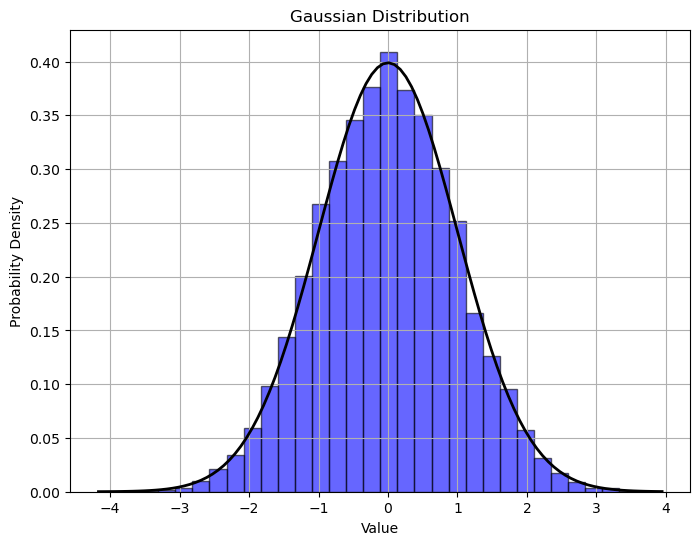

In [6]:
# Plot the histogram of the generated samples
plt.figure(figsize=(8, 6))
plt.hist(gaussian_samples, bins=30, density=True, alpha=0.6, color='blue', edgecolor='black')

# Plot the probability density function (PDF) of the Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-0.5 * ((x - mean) / std_dev) ** 2) / (std_dev * np.sqrt(2 * np.pi))  # PDF formula
plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution')
plt.grid(True)
plt.show()

In [7]:

# Parameters for the first Gaussian distribution
mean1 = 0  # Mean of the first distribution
std_dev1 = 1  # Standard deviation of the first distribution

# Parameters for the second Gaussian distribution with 62% overlap
overlap = 0.99#0.62  # Desired overlap
std_dev2 = std_dev1  # Keep the standard deviation the same for simplicity

# # Calculate the mean of the second distribution for the desired overlap
mean2 = mean1 - std_dev * np.sqrt(2 * np.log(1 / overlap))

# Generate random samples from the first Gaussian distribution
num_samples = 30  # Number of samples
gaussian_samples1 = np.random.normal(mean1, std_dev1, num_samples)

# Generate random samples from the second Gaussian distribution
gaussian_samples2 = np.random.normal(mean2, std_dev2, num_samples)


In [61]:
%%time
loops = 1000
overlap_pvalue_tuple_list = []
for overlap in np.arange(1, 0.5, -0.001):
    #print(overlap, end='')
    # Calculate the mean of the second distribution for the desired overlap
    mean2 = mean1 - std_dev * np.sqrt(2 * np.log(1 / overlap))
    # Generate random samples from the second Gaussian distribution

    p_value_list = np.zeros(loops)
    for i in range(loops):
        gaussian_samples2 = np.random.normal(mean2, std_dev2, num_samples)
        pvalue = kstest(gaussian_samples1, gaussian_samples2).pvalue
        p_value_list[i] += pvalue
    overlap_pvalue_tuple_list.append((overlap, p_value_list))

CPU times: user 1min 2s, sys: 16.7 ms, total: 1min 2s
Wall time: 1min 2s


In [87]:
@jit(nopython=True)
def compute_mean_std(arrays):
    means = np.zeros(arrays.shape[0])
    stds = np.zeros(arrays.shape[0])
    for i in range(arrays.shape[0]):
        means[i] = np.round(np.mean(arrays[i]), 3)
        stds[i] = np.round(np.std(arrays[i]), 3)
    return means, stds

In [63]:
# Extract all arrays into a single numpy array
arrays = np.array([tup[1] for tup in overlap_pvalue_tuple_list])

# Compute means and stds
means, stds = compute_mean_std(arrays)

# Combine with original values
mean_std_overlap_dict = {overlap_pvalue_tuple_list[i][0]:{'mean': means[i], 'std': stds[i]} for i in range(len(overlap_pvalue_tuple_list))}

In [80]:
overlap_list = np.array(list(mean_std_overlap_dict)) 
overlap_list[:5]

array([1.   , 0.999, 0.998, 0.997, 0.996])

In [76]:
stds = np.array(list(map(lambda x:x['std'], mean_std_overlap_dict.values())))
stds[:5]

array([0.25 , 0.253, 0.253, 0.257, 0.264])

In [77]:
means = np.array(list(map(lambda x:x['mean'], mean_std_overlap_dict.values())))
means[:5]

array([0.652, 0.655, 0.616, 0.639, 0.626])

In [81]:
pvalue_corresond_with_62_overlap = means[np.argmin(np.abs(overlap_list-0.62))]
pvalue_corresond_with_62_overlap

0.021

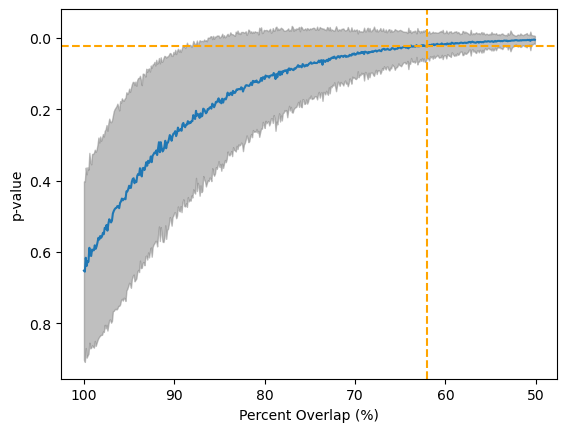

In [88]:
fig, ax = plt.subplots()
ax.plot(overlap_list*100, means)
ax.fill_between(overlap_list*100, means-stds, means+stds, color='grey', alpha=0.5, zorder=-100)
ax.invert_yaxis(); ax.invert_xaxis()
ax.axvline(62, linestyle='--', color='orange')
ax.axhline(pvalue_corresond_with_62_overlap, linestyle='--', color='orange')

ax.set_ylabel('p-value');
ax.set_xlabel('Percent Overlap (%)');

In [41]:
mean1, mean2

(0, -0.1417768376957358)

In [42]:
kstest(gaussian_samples1, gaussian_samples2).pvalue

0.9084105017744525

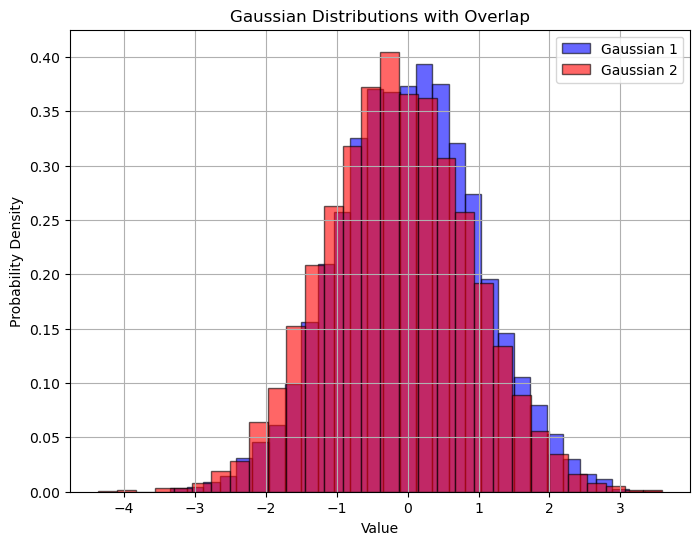

In [38]:

# Plot the histograms of the generated samples
plt.figure(figsize=(8, 6))
plt.hist(gaussian_samples1, bins=30, density=True, alpha=0.6, color='blue', label='Gaussian 1', edgecolor='black')
plt.hist(gaussian_samples2, bins=30, density=True, alpha=0.6, color='red', label='Gaussian 2', edgecolor='black')

plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Gaussian Distributions with Overlap')
plt.legend()
plt.grid(True)